# Fine Tuning Transformer for MultiClass Text Classification
- Language Model Used: **DistilBERT** this is a smaller transformer model as compared to BERT or Roberta. It is created by process of distillation applied to Bert.
- Script Objective: The objective of this script is to fine tune DistilBERT to be able to classify a news headline into the following categories:
  1. Participation matters
  2. have extra credit
  3. engaging lecture
  4. helpful office hour
  5. heavy workload
  6. (Others)

## Importing and Pre-Processing the domain data


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

%matplotlib inline
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# Read data
input_path = "/content/drive/My Drive/Rebuild my Professor/Clusters_xue_Mar7/"
participation = pd.read_csv(input_path + "participation2_final.csv", names=["id", "sentence", "cat"], header=0)
bonus = pd.read_csv(input_path + "a23-Extra Credit.csv", names=["id", "sentence", "cat"], header=0)
lecture = pd.read_csv(input_path + "a12 - Funny Lectures.csv", names=["id", "sentence", "cat"], header=0)
office_hour = pd.read_csv(input_path + "a3 - helpful office hour.csv", names=["id", "sentence", "cat"], header=0) 
other = pd.read_excel(input_path + "other.xlsx", names=["id", "sentence", "cat"], header=0)
workload = pd.read_excel(input_path + "workload.xlsx", names=["id", "sentence", "cat"], header=0)

In [ ]:
# Remove unlabeled data
participation = participation[:243]
participation["cat"] = participation["cat"].fillna(0)
participation.loc[participation["cat"] == 1, "cat"] = 1

bonus["cat"] = bonus["cat"].fillna(0)
bonus.loc[bonus["cat"] == 1, "cat"] = 2

lecture["cat"] = lecture["cat"].fillna(0)
lecture.loc[lecture["cat"] == 2, "cat"] = 3

office_hour = office_hour[:180]
office_hour["cat"] = office_hour["cat"].fillna(0)
office_hour.loc[office_hour["cat"] == 3, "cat"] = 4

workload["cat"] = workload["cat"].fillna(0)
workload.loc[workload["cat"] == 1, "cat"] = 5

other = other[:200]
other.loc[other["cat"] == 1, "cat"] = 0
other = other.loc[other["cat"] == 0, :]

In [ ]:
data = pd.concat([participation, bonus, lecture, office_hour, workload, other]).reset_index().drop(["index", "id"], axis=1)
data["cat"].value_counts()

0.0    448
3.0    288
2.0    185
4.0    157
1.0    127
5.0    125
Name: cat, dtype: int64

In [ ]:
data

,sentence,cat
0,"As long as you do the work, participate in class, and watch the films, you will do fine.",1.0
1,"Summers is the man, and as long as you show up and contribute to class, you'll be fine.",1.0
2,"For tests, just know the review guide and which authors said what, and you'll be fine.",0.0
3,Come to class and you will be fine.,1.0
4,Classes were lecture heavy - study them and you'll do fine.,1.0
...,...,...
1325,Great professor!!,0.0
1326,"The class is pretty easy, but of course, you have to put in a lot of effort into the projects.",0.0
1327,"Bella is a cool person, and she loves to see her students succeed.",0.0
1328,"Also, he gives 5 pop-quizzes so beware.",0.0


## Importing Python Libraries and preparing the environment

In [ ]:
!pip3 install transformers

In [ ]:
# Importing the libraries needed
import torch
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer

In [ ]:
# Setting up the device for GPU usage (for Cuda execution)
# This configuration is needed if we want to leverage on onboard GPU.
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

##  Preparing the Dataset and Dataloader



### Defining Key Metrics

In [ ]:
% pip install sentencepiece

In [ ]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 64
TRAIN_BATCH_SIZE = 6
VALID_BATCH_SIZE = 6
EPOCHS = 5
LEARNING_RATE = 8e-05
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


### *Triage* Dataset Class

This defines how the text is pre-processed before sending it to the neural network.


In [ ]:
class Triage(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        sentence = str(self.data.sentence[index])
        sentence = " ".join(sentence.split())
        inputs = self.tokenizer.encode_plus(
            sentence,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.cat[index], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

### Dataloader
Dataset and Dataloader are constructs of the PyTorch library for defining and controlling the data pre-processing and its passage to neural network. 

In [ ]:
# Creating the dataset and dataloader for the neural network

train_size = 0.8

train_dataset = data.sample(frac=train_size,random_state=2000)
validate_dataset = data.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("VALIDATE Dataset: {}".format(validate_dataset.shape))

training_set = Triage(train_dataset, tokenizer, MAX_LEN)
validating_set = Triage(validate_dataset, tokenizer, MAX_LEN)

FULL Dataset: (1330, 2)
TRAIN Dataset: (1064, 2)
VALIDATE Dataset: (266, 2)


In [ ]:
# validating_set.groupby('cat').count()

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

validate_params = {'batch_size': VALID_BATCH_SIZE,
                   'shuffle': False,
                   'num_workers': 0
                   }

training_loader = DataLoader(training_set, **train_params)
validating_loader = DataLoader(validating_set, **validate_params)

## Creating the Neural Network for Fine Tuning


#### Neural Network


In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained('distilbert-base-uncased')

        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.8)
        self.dropout2 = torch.nn.Dropout(0.5)
        self.classifier = torch.nn.Linear(768, 6)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]

        pooler = self.dropout2(pooler)
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [ ]:
model = DistillBERTClass()
model.to(device)

DistillBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_feat

### Loss Function and Optimizer


In [ ]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
loss_function_val = torch.nn.CrossEntropyLoss()

# `weight_decay` helps prevent overfitting
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

## Fine Tuning the Model

In [ ]:
# Function to calcuate the accuracy of the model
def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [ ]:
# An array to store epoch and loss/acc data
epoch_loss_train = []
epoch_accu_train = []

epoch_loss_validate = []
epoch_accu_validate = []

In [ ]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model

def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    # The dataloader passes data to the model based on the batch size.
    for _,data in enumerate(training_loader, 0):
        
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        # Subsequent output from the model and the actual category are compared to calculate the loss.
        outputs = model(ids, mask)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accu(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        # After every 100 steps the loss value is printed in the console.
        if _%100==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(f"Training Loss per 100 steps: {loss_step}")
            print(f"Training Accuracy per 100 steps: {accu_step}")

        # Loss value is used to optimize the weights of the neurons in the network.
        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}\n")

    # validating
    val_loss = 0
    n_correct_val = 0
    nb_tr_steps_val = 0
    nb_tr_examples_val = 0
    
    for _,data in enumerate(validating_loader, 0):
        model.eval()
        with torch.no_grad():

            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)

            outputs = model(ids, mask)
            loss = loss_function_val(outputs, targets)
            val_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct_val += calcuate_accu(big_idx, targets)

            nb_tr_steps_val += 1
            nb_tr_examples_val+=targets.size(0)

    epoch_loss_val = val_loss/nb_tr_steps_val
    epoch_accu_val = (n_correct_val*100)/nb_tr_examples_val
    print(f"Validating Loss Epoch: {epoch_loss_val}")
    print(f"Validating Accuracy Epoch: {epoch_accu_val}\n\n")

    epoch_loss_train.append([epoch, epoch_loss])
    epoch_accu_train.append([epoch, epoch_accu])
    epoch_loss_validate.append([epoch, epoch_loss_val])
    epoch_accu_validate.append([epoch, epoch_accu_val])

    return 

In [ ]:
for epoch in range(EPOCHS):
    train(epoch)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Training Loss per 100 steps: 1.8657984733581543
Training Accuracy per 100 steps: 0.0
Training Loss per 100 steps: 1.3837823720261602
Training Accuracy per 100 steps: 46.36963696369637
The Total Accuracy for Epoch 0: 58.64661654135338
Training Loss Epoch: 1.1149219384186724
Training Accuracy Epoch: 58.64661654135338

Validating Loss Epoch: 0.5657112557027075
Validating Accuracy Epoch: 82.33082706766918


Training Loss per 100 steps: 0.9040897488594055
Training Accuracy per 100 steps: 83.33333333333333
Training Loss per 100 steps: 0.4873429502148439
Training Accuracy per 100 steps: 84.48844884488449
The Total Accuracy for Epoch 1: 84.77443609022556
Training Loss Epoch: 0.489931396574954
Training Accuracy Epoch: 84.77443609022556

Validating Loss Epoch: 0.5011741560366418
Validating Accuracy Epoch: 81.95488721804512


Training Loss per 100 steps: 0.07757089287042618
Training Accuracy per 100 steps: 100.0
Training Loss per 100 steps: 0.30748985167408344
Training Accuracy per 100 steps: 92.

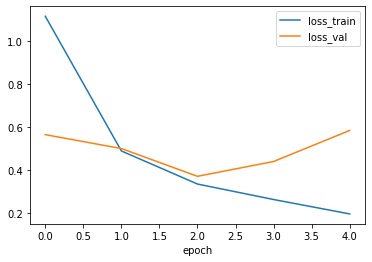

In [ ]:
ax = pd.DataFrame(epoch_loss_train, columns=['epoch', 'loss_train']).plot(x ='epoch', y='loss_train', kind = 'line') 
ax = pd.DataFrame(epoch_loss_validate, columns=['epoch', 'loss_val']).plot(x ='epoch', y='loss_val', kind = 'line', ax=ax) 


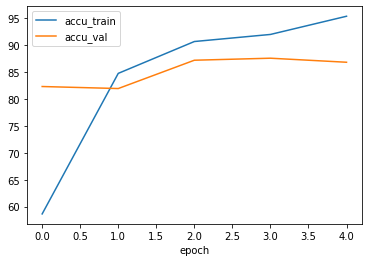

In [ ]:
ax2 = pd.DataFrame(epoch_accu_train, columns=['epoch', 'accu_train']).plot(x ='epoch', y='accu_train', kind = 'line') 
ax2 = pd.DataFrame(epoch_accu_validate, columns=['epoch', 'accu_val']).plot(x ='epoch', y='accu_val', ax=ax2) 

## Validating the Model

In [ ]:
y_true = [] # arr that holds the true labels
y_pred = [] # arr that holds prediction
y_fasle = [] # arr that stores false prediction

def valid(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0
    tr_loss = 0; nb_tr_steps = 0; nb_tr_examples = 0

    # accuracy per class
    with torch.no_grad():
        for index, data in enumerate(testing_loader, 0):

            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accu(big_idx, targets)

            for i in range(VALID_BATCH_SIZE):
                if i >= len(big_idx):
                    break
                if big_idx[i] != targets[i]:
                    y_fasle.append([index*VALID_BATCH_SIZE+i ,targets[i].cpu().numpy(), big_idx[i].cpu().numpy()])

            y_true.extend(targets.cpu().numpy())
            y_pred.extend(big_idx.cpu().numpy())

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            if index%50==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 50 steps: {loss_step}")
                print(f"Validation Accuracy per 50 steps: {accu_step}")

    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return epoch_accu


In [ ]:
print('This is the validation section to print the accuracy and see how it performs')

acc = valid(model, validating_loader)
print("Accuracy on test data = %0.2f%%" % acc)

This is the validation section to print the accuracy and see how it performs
Validation Loss per 50 steps: 1.312503457069397
Validation Accuracy per 50 steps: 66.66666666666667


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Validation Loss Epoch: 0.5850310710672703
Validation Accuracy Epoch: 86.84210526315789
Accuracy on test data = 86.84%


### Accuracy per Class

In [ ]:
from sklearn.metrics import confusion_matrix
target_names = ['other', 'participation', 'bonus', 'lecture' 'oh', 'workload', ]

# Get the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# normalize the diagonal entries
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#The diagonal entries are the accuracies of each class
cm.diagonal()

array([0.78378378, 0.91666667, 0.95348837, 0.9       , 1.        ,
       0.67857143])

In [ ]:
validate_dataset.iloc[0]

sentence    If you go to lecture (attendance taken) and do the readings you'll be fine.
cat                                                                                   1
Name: 0, dtype: object

### False Prediction

In [ ]:
pd.options.display.max_colwidth = 200

for each in y_fasle:
    print(validate_dataset.iloc[each[0]])
    print(each[1])
    print(each[2])
    print()

sentence    Take notes from textbook and pay attention in class/discussion and you'll get an easy A Go to lecture and you'll be just fine.
cat                                                                                                                                      0
Name: 1, dtype: object
0
1

sentence    If you follow her instructions and show up to class you should be fine.
cat                                                                               0
Name: 3, dtype: object
0
1

sentence    Study the slides, do the quizzes, be there for class and honestly you'll be just fine.
cat                                                                                              1
Name: 22, dtype: object
1
0

sentence    Easy tests, but make sure you go to class and learn how to write proofs.
cat                                                                                1
Name: 32, dtype: object
1
0

sentence    If you put in the work before you come, pay attention while 

## Saving the Trained Model Artifacts for inference



In [ ]:
output_model_file = '/content/drive/My Drive/Rebuild my Professor/models/classification_model.pt'

torch.save(model.state_dict(), output_model_file)

### Make Prediction

In [ ]:
model.load_state_dict(torch.load(output_model_file))

<All keys matched successfully>

In [ ]:
def predict(model, tokenizer, sentence):
    model.eval()

    sentence = " ".join(sentence.split())
    inputs = tokenizer.encode_plus(
        sentence,
        None,
        add_special_tokens=True,
        max_length=MAX_LEN,
        pad_to_max_length=True,
        return_token_type_ids=True,
        truncation=True
    )
    ids = inputs['input_ids']
    mask = inputs['attention_mask']

    ids = torch.tensor(ids, dtype=torch.long).to(device, dtype = torch.long).unsqueeze(0)
    mask =  torch.tensor(mask, dtype=torch.long).to(device, dtype = torch.long).unsqueeze(0)
    outputs = model(ids, mask).squeeze()
  
    _, big_idx = torch.max(outputs.data, 0)

    return big_idx.item()

In [ ]:
predict(model, tokenizer, "Have extra credit")

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


2